In [5]:
import requests
url = 'https://storage.googleapis.com/wandb_datasets/nature_12K.zip'
r = requests.get(url, allow_redirects=True)
open('nature_12K.zip', 'wb').write(r.content)
!wget 'https://storage.googleapis.com/wandb_datasets/nature_12K.zip'
!unzip nature_12K.zip

In [6]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
!pip install wandb
import wandb

In [ ]:
import pandas as pd
import os
import keras
import tensorflow as tf
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import cv2
#from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

#from tensorflow.keras.metrics import categorical_crossentropy
# from keras.layers.normalization import BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def data(image_size,augment_data,batch_size):
      home_path = "/content/inaturalist_12K"
      train_path = os.path.join(home_path,'train')
      test_path = os.path.join(home_path,'val')
      if augment_data == True:
        print("swe")
        train_data = ImageDataGenerator(rotation_range=10, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True,brightness_range=[0.2,1.2],validation_split=0.1) # brightness
        test_data = ImageDataGenerator(rotation_range=10, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True,brightness_range=[0.2,1.2]) # brightness

      else:
        train_data = ImageDataGenerator(rescale=1./255, validation_split=0.1)
        test_data = ImageDataGenerator(rescale=1./255)


      train_generator = train_data.flow_from_directory(directory= train_path,target_size=(image_size, image_size), batch_size=batch_size,color_mode="rgb",class_mode="categorical",subset = "training")
      val_generator = train_data.flow_from_directory(directory= train_path,target_size=(image_size, image_size), batch_size=batch_size,color_mode="rgb",class_mode="categorical",subset = "validation")
      test_generator = test_data.flow_from_directory(directory= test_path,target_size=(image_size, image_size), batch_size=batch_size,color_mode="rgb",class_mode="categorical")
      return train_generator,val_generator,test_generator

def CNN_model(image_size,kernel_size,num_filters,filter_org,dropout,batch_norm,epochs,dense_size,lr):
            if filter_org == "same":
                filters = [num_filters,num_filters,num_filters,num_filters,num_filters]
            if filter_org == "doubling":
                filters = [num_filters,num_filters*2,num_filters*4,num_filters*8,num_filters*16]
            if filter_org == "halving":
                filters = [num_filters,int(num_filters/2),int(num_filters/4),int(num_filters/8),int(num_filters/16)]

            nature_model = Sequential()
            nature_model.add(Conv2D(filters[0], kernel_size=(kernel_size, kernel_size),activation='relu',input_shape=(image_size,image_size,3)))
            if batch_norm == True:
                          print("batch_norm")
                          nature_model.add(BatchNormalization())
            nature_model.add(MaxPooling2D(2, 2))

            nature_model.add(Conv2D(filters[1], kernel_size=(kernel_size, kernel_size),activation='relu',input_shape=(image_size,image_size,3)))
            if batch_norm == True:
                          nature_model.add(BatchNormalization())
            nature_model.add(MaxPooling2D(2, 2)) 

            nature_model.add(Conv2D(filters[2], kernel_size=(kernel_size, kernel_size),activation='relu',input_shape=(image_size,image_size,3)))
            if batch_norm == True:
                          nature_model.add(BatchNormalization())
            nature_model.add(MaxPooling2D(2, 2))  

            nature_model.add(Conv2D(filters[3], kernel_size=(kernel_size, kernel_size),activation='relu',input_shape=(image_size,image_size,3)))
            if batch_norm == True:
                          nature_model.add(BatchNormalization())
            nature_model.add(MaxPooling2D(2, 2)) 

            nature_model.add(Conv2D(filters[4], kernel_size=(kernel_size, kernel_size),activation='relu',input_shape=(image_size,image_size,3)))
            if batch_norm == True:
                          nature_model.add(BatchNormalization())
            nature_model.add(MaxPooling2D(2, 2))             
            nature_model.add(Flatten())
            nature_model.add(Dense(dense_size, activation='relu'))
            nature_model.add(Dropout(dropout))

            
            nature_model.add(Dense(10, activation='softmax'))
            return nature_model



In [ ]:
train_gen, val_gen, test_gen = data(image_size=200,augment_data=False,batch_size=200)
model = CNN_model(image_size=200,kernel_size=3,num_filters=64, filter_org="same",dropout=0.3, batch_norm=False,epochs=10,dense_size=64,lr=0.001)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="categorical_accuracy")
model.fit(train_gen,validation_data=val_gen,epochs=15)
model.save("my_best_model.h5")
model.summary()


In [9]:
model = tf.keras.models.load_model('my_best_model.h5')
score = model.evaluate(test_gen,batch_size=200)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])
Test_accuracy = {"loss":score[0],"Test_accuracy":score[1]}
wandb.init(entity='swe-rana',project='CS6910_Assignment2')
wandb.log(Test_accuracy)
predictions = model(test_gen[0][0])

10/10 [==============================] - 81s 8s/step - loss: 1.8107 - categorical_accuracy: 0.3775
Test loss: 1.8107361793518066
Test accuracy: 0.3774999976158142


wandb: Currently logged in as: swe-rana (use `wandb login --relogin` to force relogin)


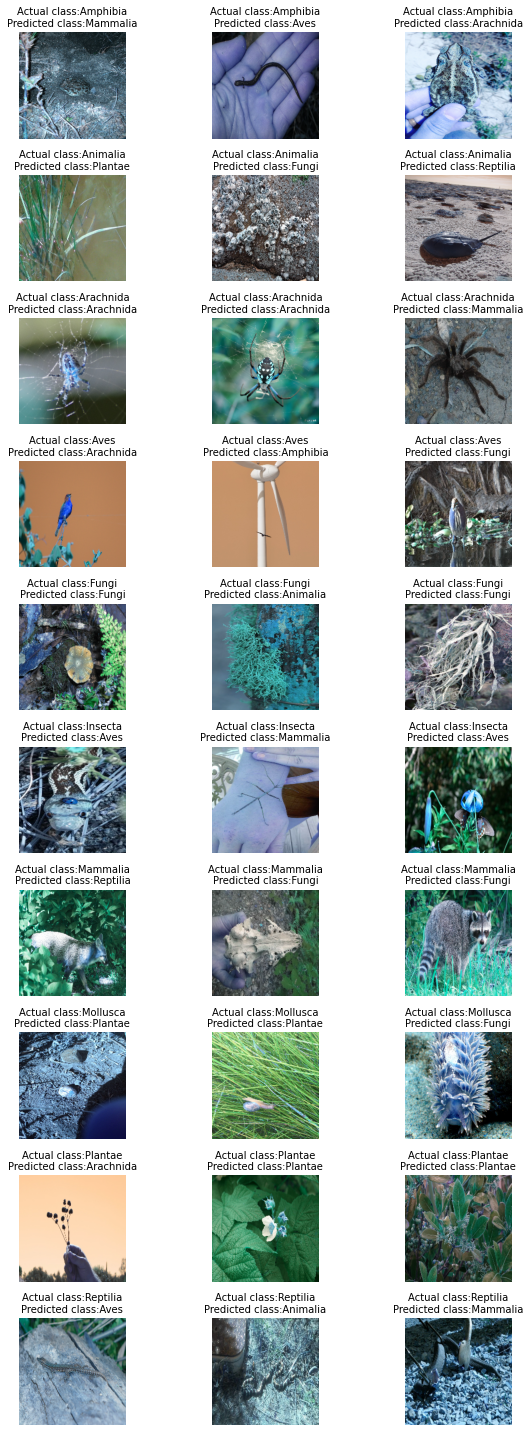

In [15]:
classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
test_path = "/content/inaturalist_12K/val"
im_1,im_2,predictions=[],[],[]
for label in classes:
    i=0
    path=os.path.join(test_path,label)
    for img in os.listdir(path):
      if i==3:
        break
      try:
        image = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
        im_1.append(image)
        im_2.append(label)
        imag = cv2.resize(image, (200,200)) / 255.0
        prediction = model.predict(imag.reshape(1,200, 200,3))
        c=prediction.argmax()
        predictions.append(classes[c])
        i+=1
      except:
        break

#plotting a 10x3 grid with predictions
fig = plt.figure(figsize=(10,20))
rows,columns=10,3
i=1
for k in range(30):

  img=cv2.resize(x[k],(200,200))
  fig.add_subplot(rows,columns,i)
  plt.imshow(img)
  plt.title('Actual class:'+im_2[k]+  "\n" +'Predicted class:'+predictions[k],fontdict={'fontsize':10})
  plt.axis("off")
  plt.tight_layout()
  #plt.axis('off')
  i+=1   
wandb.init(entity='swe-rana',project='CS6910_Assignment2')
wandb.log({'predicting on sample images':plt})

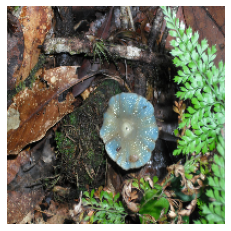

In [16]:
from tensorflow.keras.models import Model

partial_model = Model(inputs=model.inputs, outputs=model.layers[0].output)
image, label = test_gen.next()

plt.imshow(image[0])
plt.axis("off")
plt.show()

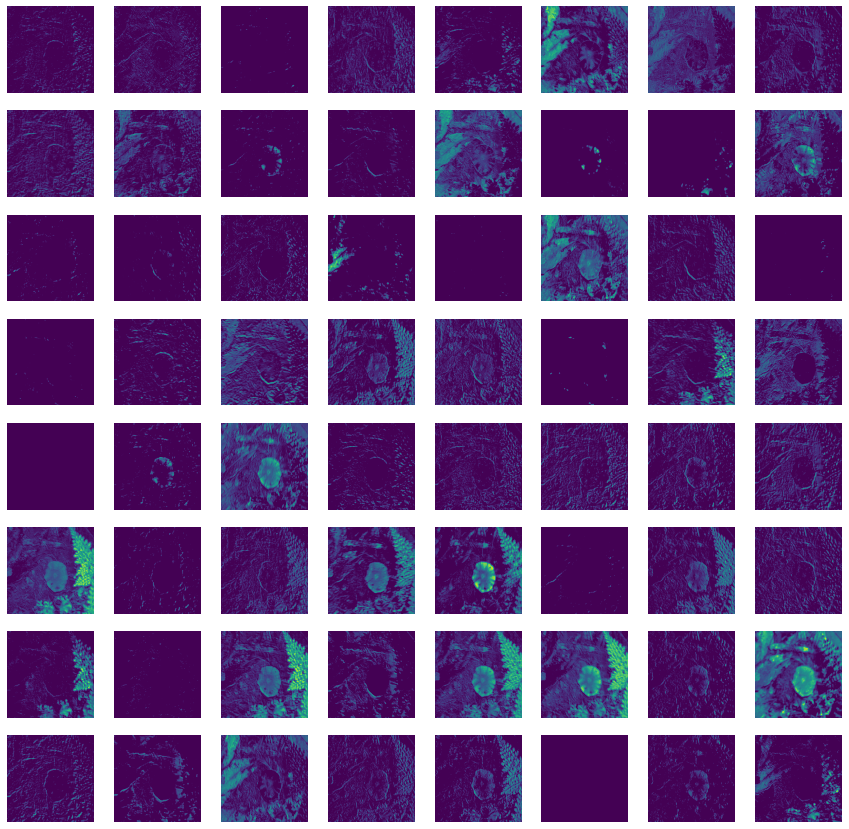

In [17]:
feature_maps = partial_model.predict(image)

plt.figure(figsize=(15, 15))
for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(feature_maps[0,:,:,i])
    plt.axis("off")